RANDOM FOREST MODEL ONLY

In [1]:
import pandas as pd
import numpy as np
import pickle


import matplotlib.pyplot as plt #to visualise
import seaborn as sns

import nltk #to vectorizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer #to find the similarity

#Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #not regression
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.exceptions import NotFittedError


import re

In [2]:
laptop = pd.read_csv('dataset/laptops.csv')
laptop.shape

(796, 16)

In [3]:
laptop.columns

Index(['laptop_id', 'name', 'price', 'processor', 'ram', 'os', 'storage',
       'img_link', 'display', 'rating', 'no_of_ratings', 'no_of_reviews',
       'laptop_brand', 'os_brand', 'processor_brand', 'usecases'],
      dtype='object')

### HANDLING OUTLIER

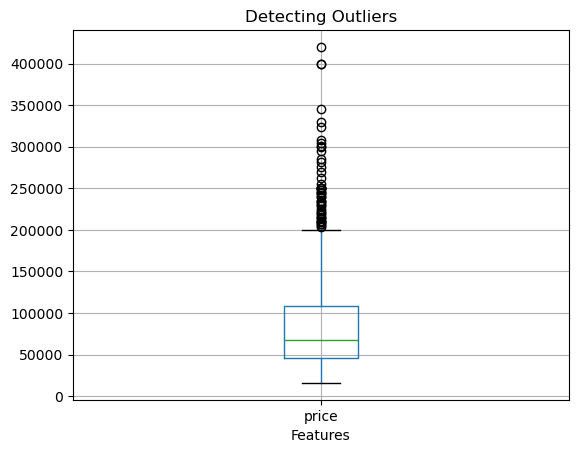

In [4]:
laptop.boxplot(column=['price'])
plt.title("Detecting Outliers")
plt.xlabel('Features')
plt.show()

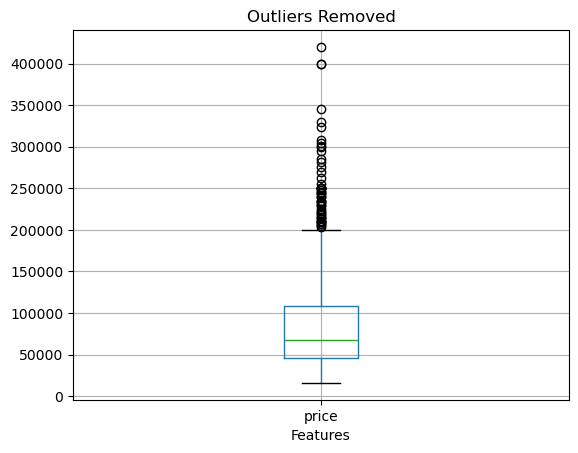

In [5]:
# function to detect outliers in a column
def findOutliers(data,col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3 - q1
    
    upper_bound = q3 + (1.5 * iqr)
    lower_bound = q1 - (1.5 * iqr)
    
    outliersList = data.index[ (data[col] < lower_bound) | (data[col] > upper_bound)] 
    
    return outliersList

# find outliers in the columns
indexList = []
for col in ['price']:
    indexList.extend(findOutliers(laptop,col))

# remove the outliers
def removeOutliers(data,outliersList):
    outliersList = sorted(set(outliersList))
    data = data.drop(outliersList)
    return data

data = removeOutliers(laptop,indexList)

laptop.boxplot(column=['price'])
plt.title("Outliers Removed")
plt.xlabel('Features')
plt.show()

# DATA PREPROCESS

In [6]:
print(laptop.dtypes)

laptop_id            int64
name                object
price                int64
processor           object
ram                 object
os                  object
storage             object
img_link            object
display            float64
rating             float64
no_of_ratings      float64
no_of_reviews      float64
laptop_brand        object
os_brand            object
processor_brand     object
usecases            object
dtype: object


In [7]:
#Drop 4 columns
laptop.drop(columns=['no_of_ratings', 'no_of_reviews', 'rating', 'os', 'processor_brand'], inplace=True) #To drop column

laptop.rename(columns={'laptop_brand': 'brand', 'os_brand': 'os'}, inplace=True)

In [8]:
print(laptop.isnull().sum())
print(laptop.duplicated().sum())

laptop_id    0
name         0
price        0
processor    0
ram          0
storage      0
img_link     0
display      0
brand        0
os           0
usecases     0
dtype: int64
0


In [9]:
laptop.dropna(inplace=True)

In [10]:
print('ANY NULL VALUE: ', laptop.isnull().sum())
print('ANY DUPLICATION: ', laptop.duplicated().sum())
print('DF SHAPE: ', laptop.shape)

ANY NULL VALUE:  laptop_id    0
name         0
price        0
processor    0
ram          0
storage      0
img_link     0
display      0
brand        0
os           0
usecases     0
dtype: int64
ANY DUPLICATION:  0
DF SHAPE:  (796, 11)


# DATA TRANSFORM
## A. CURRECNCY

In [11]:
laptop['price'] = laptop['price'] * 0.055 

## B. RAM

In [12]:
laptop['ram'].value_counts().head()

ram
8 GB DDR4 RAM       332
16 GB DDR4 RAM      187
16 GB DDR5 RAM       69
4 GB DDR4 RAM        42
8 GB LPDDR4X RAM     23
Name: count, dtype: int64

In [13]:
#need to extract value of each RAM and create column for each value/category
#we extracts numeric values from the text, and convert into integer
laptop['ram'] = laptop['ram'].str.extract('(\d+)').astype(int)

laptop['ram'].value_counts().head()

ram
8     386
16    314
4      61
32     35
Name: count, dtype: int64

## C. DISPLAY

In [14]:
sorted(laptop['display'].unique())

[11.6,
 12.0,
 13.3,
 13.4,
 13.5,
 13.6,
 14.0,
 14.1,
 14.2,
 14.5,
 14.96,
 15.0,
 15.3,
 15.6,
 16.0,
 16.1,
 16.2,
 16.6,
 17.0,
 17.3,
 35.0]

In [15]:
laptop['display'] = laptop['display'].astype(int)
sorted(laptop['display'].unique())

[11, 12, 13, 14, 15, 16, 17, 35]

In [16]:
'''def transform_display(x):
    if x <= 18:
        return 1 #child
    elif x > 18 and x < 65:
        return 2 #adult
    elif x >= 65:
        return 3 #old

data['Age'] = data['Age'].apply(transform_age)'''

"def transform_display(x):\n    if x <= 18:\n        return 1 #child\n    elif x > 18 and x < 65:\n        return 2 #adult\n    elif x >= 65:\n        return 3 #old\n\ndata['Age'] = data['Age'].apply(transform_age)"

## D. STORAGE (GB)

In [17]:
laptop['storage'] = laptop['storage'].str.extract('(\d+)').astype(int)
print(laptop['storage'].value_counts())

#laptop[laptop['storage'] == 4]

storage
512    452
1      226
256     95
2       12
128      8
4        2
5        1
Name: count, dtype: int64


In [18]:
laptop['storage'] = laptop['storage'].apply(lambda x: 1000 if x == 1 else x)
laptop['storage'] = laptop['storage'].apply(lambda x: 2000 if x == 2 else x)
laptop['storage'] = laptop['storage'].apply(lambda x: 1000 if x == 4 else x)
laptop['storage'] = laptop['storage'].apply(lambda x: 1000 if x == 5 else x)

print(laptop['storage'].value_counts())

storage
512     452
1000    229
256      95
2000     12
128       8
Name: count, dtype: int64


## E. USECASE, TYPE OF LAPTOP

In [19]:
#laptop['usecases'].unique() #to display all usecase without total them
laptop['usecases'].value_counts()

usecases
 Gaming                      263
 Business/Professional       163
 Home/Everyday use           100
 Budget Friendly              68
 Creative/Design              64
 Student/Education            54
 Multimedia/Entertainment     48
Ultra-portable                36
Name: count, dtype: int64

#### OPTION 1 - only 3 types (gaming, office, hybrid)

In [20]:
# Define a mapping dictionary
'''category_mapping = {
    ' Gaming': 'Gaming',
    ' Business/Professional': 'Office',
    ' Budget Friendly': 'Office',
    ' Home/Everyday use': 'Hybrid',
    ' Student/Education': 'Hybrid',
    ' Creative/Design': 'Hybrid',
    ' Multimedia/Entertainment': 'Hybrid',
    'Ultra-portable': 'Hybrid'
}'''
# Apply the mapping to the 'usecases' column
#laptop['usecases'] = laptop['usecases'].map(category_mapping) #jgn guna ni sbb effect pada jupyter
laptop['usecases'] = laptop['usecases'].replace(' Gaming', 'Gaming')
laptop['usecases'] = laptop['usecases'].replace(' Business/Professional', 'Office')
laptop['usecases'] = laptop['usecases'].replace(' Budget Friendly', 'Office')
laptop['usecases'] = laptop['usecases'].replace(' Home/Everyday use', 'Hybrid')
laptop['usecases'] = laptop['usecases'].replace(' Student/Education', 'Hybrid')
laptop['usecases'] = laptop['usecases'].replace(' Creative/Design', 'Hybrid')
laptop['usecases'] = laptop['usecases'].replace(' Multimedia/Entertainment', 'Hybrid')
laptop['usecases'] = laptop['usecases'].replace('Ultra-portable', 'Hybrid')

print(laptop['usecases'].value_counts())
print('\n',laptop.dtypes)

usecases
Hybrid    302
Gaming    263
Office    231
Name: count, dtype: int64

 laptop_id      int64
name          object
price        float64
processor     object
ram            int32
storage        int64
img_link      object
display        int32
brand         object
os            object
usecases      object
dtype: object


In [21]:
le_usecases = LabelEncoder()
laptop['usecases'] = le_usecases.fit_transform(laptop['usecases'])
print(laptop["usecases"].unique())
print(laptop['usecases'].value_counts())

[2 0 1]
usecases
1    302
0    263
2    231
Name: count, dtype: int64


#### OPTION 2 - convert into 1, 2, 3 (gaming, office, hybrid)
no difference

In [22]:
'''laptop['usecases'] = laptop['usecases'].replace('Gaming', 1)
laptop['usecases'] = laptop['usecases'].replace('Office', 2)
laptop['usecases'] = laptop['usecases'].replace('Hybrid', 3)

print(laptop['usecases'].value_counts())
print(laptop.dtypes)'''

"laptop['usecases'] = laptop['usecases'].replace('Gaming', 1)\nlaptop['usecases'] = laptop['usecases'].replace('Office', 2)\nlaptop['usecases'] = laptop['usecases'].replace('Hybrid', 3)\n\nprint(laptop['usecases'].value_counts())\nprint(laptop.dtypes)"

## F. OS

In [23]:
print(laptop['os'].value_counts())

os
Windows     738
MacOS        37
ChromeOS     14
DOS           7
Name: count, dtype: int64


In [24]:
#OPTION 1

le_os = LabelEncoder()
laptop['os'] = le_os.fit_transform(laptop['os'])
print(laptop["os"].unique())
print(laptop['os'].value_counts())

[3 1 2 0]
os
3    738
2     37
0     14
1      7
Name: count, dtype: int64


In [25]:
#OPTION 2

'''laptop['os'] = laptop['os'].replace('Windows', 1)
laptop['os'] = laptop['os'].replace('MacOS', 2)
laptop['os'] = laptop['os'].replace('ChromeOS', 3)
laptop['os'] = laptop['os'].replace('DOS', 4)

print(laptop['os'].value_counts())
print('\n',laptop.dtypes)'''

"laptop['os'] = laptop['os'].replace('Windows', 1)\nlaptop['os'] = laptop['os'].replace('MacOS', 2)\nlaptop['os'] = laptop['os'].replace('ChromeOS', 3)\nlaptop['os'] = laptop['os'].replace('DOS', 4)\n\nprint(laptop['os'].value_counts())\nprint('\n',laptop.dtypes)"

## G. CPU

In [26]:
laptop['processor'].value_counts()

processor
AMD Ryzen 7 Octa Core Processor                 81
Intel Core i5 Processor (12th Gen)              81
AMD Ryzen 5 Hexa Core Processor                 76
Intel Core i3 Processor (11th Gen)              73
Intel Core i5 Processor (11th Gen)              72
Intel Core i7 Processor (12th Gen)              63
Intel Core i5 Processor (10th Gen)              30
Intel Core i3 Processor (10th Gen)              29
Intel Core i7 Processor (11th Gen)              26
Intel Core i7 Processor (10th Gen)              26
Intel Celeron Dual Core Processor               23
AMD Ryzen 3 Dual Core Processor                 20
AMD Ryzen 9 Octa Core Processor                 20
Intel Core i5 Processor (8th Gen)               16
Apple M1 Processor                              13
Apple M2 Processor                              13
Intel Core i9 Processor (12th Gen)              13
Intel Core i3 Processor (12th Gen)              12
AMD Ryzen 5 Quad Core Processor                 11
AMD Ryzen 3 Quad Core

In [27]:
#intel
laptop['processor'] = laptop['processor'].apply(lambda x: 'i3' if 'i3' in str(x).lower() else x)
laptop['processor'] = laptop['processor'].apply(lambda x: 'i5' if 'i5' in str(x).lower() else x)
laptop['processor'] = laptop['processor'].apply(lambda x: 'i7' if 'i7' in str(x).lower() else x)
laptop['processor'] = laptop['processor'].apply(lambda x: 'i9' if 'i9' in str(x).lower() else x)

#ryzen
laptop['processor'] = laptop['processor'].apply(lambda x: 'ryzen 3' if 'ryzen 3' in str(x).lower() else x)
laptop['processor'] = laptop['processor'].apply(lambda x: 'ryzen 5' if 'ryzen 5' in str(x).lower() else x)
laptop['processor'] = laptop['processor'].apply(lambda x: 'ryzen 7' if 'ryzen 7' in str(x).lower() else x)
laptop['processor'] = laptop['processor'].apply(lambda x: 'ryzen 9' if 'ryzen 9' in str(x).lower() else x)

#others
keywords = ['m1','m2']
laptop['processor'] = laptop['processor'].apply(
    lambda x: 'apple' if any(keyword in str(x).lower() for keyword in keywords) else x)
keywords = ['pentium', 'celeron', 'qualcomm', 'mediatek', 'amd']
laptop['processor'] = laptop['processor'].apply(
    lambda x: 'integrated' if any(keyword in str(x).lower() for keyword in keywords) else x)


In [28]:
laptop['processor'].value_counts()

processor
i5            209
i7            132
i3            116
ryzen 5        91
ryzen 7        85
integrated     48
apple          36
ryzen 3        31
ryzen 9        24
i9             24
Name: count, dtype: int64

In [29]:
le_processor = LabelEncoder()
laptop['processor'] = le_processor.fit_transform(laptop['processor'])
print(laptop["processor"].unique())
print(laptop['processor'].value_counts())

[2 9 1 5 0 6 3 7 8 4]
processor
2    209
3    132
1    116
7     91
8     85
5     48
0     36
6     31
9     24
4     24
Name: count, dtype: int64


In [30]:
laptop.head(2)

,laptop_id,name,price,processor,ram,storage,img_link,display,brand,os,usecases
0,0,Lenovo Intel Core i5 11th Gen,3464.45,2,16,512,https://rukminim1.flixcart.com/image/312/312/x...,15,Lenovo,3,2
1,1,ASUS ROG Zephyrus G15 (2022) with 90Whr Batter...,8909.45,9,16,1000,https://rukminim1.flixcart.com/image/312/312/l...,15,ASUS,3,0


## H. LAPTOP BRAND

In [31]:
print(laptop["brand"].unique())
print(laptop['brand'].value_counts())

['Lenovo' 'ASUS' 'APPLE' 'Redmi' 'acer' 'DELL' 'realme' 'HP' 'MSI'
 'SAMSUNG' 'Infinix' 'ALIENWARE' 'GIGABYTE' 'Avita' 'Mi' 'MICROSOFT'
 'Sony' 'Ultimus' 'Nokia' 'LG']
brand
ASUS         223
HP           149
DELL         132
Lenovo        94
acer          56
MSI           51
APPLE         37
Infinix       22
GIGABYTE       6
Avita          5
ALIENWARE      4
realme         3
SAMSUNG        3
Redmi          2
Sony           2
Ultimus        2
LG             2
Mi             1
MICROSOFT      1
Nokia          1
Name: count, dtype: int64


In [32]:
le_brand = LabelEncoder()
laptop['brand'] = le_brand.fit_transform(laptop['brand'])
print(laptop["brand"].unique())
print(laptop['brand'].value_counts())

[ 9  2  1 14 18  4 19  6 11 15  7  0  5  3 12 10 16 17 13  8]
brand
2     223
6     149
4     132
9      94
18     56
11     51
1      37
7      22
5       6
3       5
0       4
19      3
15      3
14      2
16      2
17      2
8       2
12      1
10      1
13      1
Name: count, dtype: int64


## RANDOM FOREST
### DATA BALANCING

In [33]:
# Features (X) and Target (y)
X = laptop[['price', 'processor', 'ram', 'storage', 'display', 'brand', 'os']]
y = laptop['usecases']

In [34]:
#pip install --upgrade scikit-learn imbalanced-learn

c:\Users\aiman\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\aiman\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


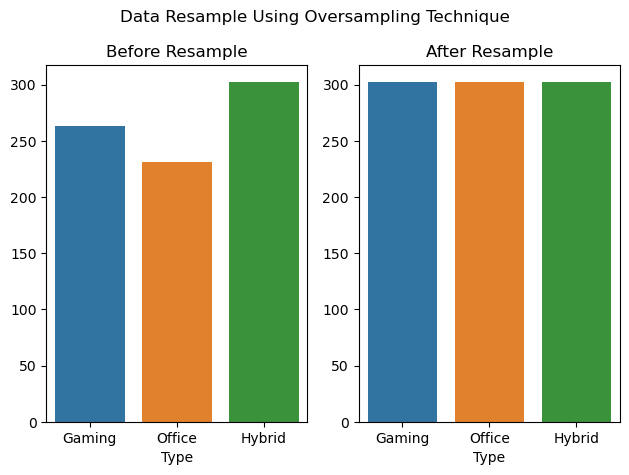

In [35]:
# barplot before balancing

fig, (ax1,ax2) = plt.subplots(1,2)
sns.barplot(x=['Gaming','Office','Hybrid'],
            y=[sum(y==0),sum(y==2),sum(y==1)],ax=ax1)

ax1.set_title("Before Resample")
ax1.set_xlabel('Type')

# oversampling technique
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X,y = sm.fit_resample(X,y)

sns.barplot(x=['Gaming','Office','Hybrid'],
            y=[sum(y==0),sum(y==2),sum(y==1)],ax=ax2)
ax2.set_title("After Resample")
ax2.set_xlabel('Type')

plt.suptitle("Data Resample Using Oversampling Technique")
plt.tight_layout()
#plt.savefig('resampled.jpg',bbox_inches='tight')
plt.show()

In [36]:
laptop.dtypes

laptop_id      int64
name          object
price        float64
processor      int32
ram            int32
storage        int64
img_link      object
display        int32
brand          int32
os             int32
usecases       int32
dtype: object

In [37]:
laptop.shape

(796, 11)

In [38]:
laptop.head(2)

,laptop_id,name,price,processor,ram,storage,img_link,display,brand,os,usecases
0,0,Lenovo Intel Core i5 11th Gen,3464.45,2,16,512,https://rukminim1.flixcart.com/image/312/312/x...,15,9,3,2
1,1,ASUS ROG Zephyrus G15 (2022) with 90Whr Batter...,8909.45,9,16,1000,https://rukminim1.flixcart.com/image/312/312/l...,15,2,3,0


In [39]:
# Train-Test Split
#X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

rf_model = RandomForestClassifier(n_estimators=40, 
                                  max_features= 2, 
                                  max_depth=10, random_state=42) # Initialize the Random Forest model
try:
    rf_model.fit(X_train, y_train)
except ValueError:
    print("Error training the model. Check your data consistency.")
    exit()

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
rf_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy(Random Forest):","{:.2%}".format(rf_accuracy))

#before tukar storage jadi interger = 0.3302, after = 0.3491
#after tukar usecase jadi 3 types only = 0.5283, even after tukar jadi 1,2,3 for each usecase, still sama
#after tukar 4 and 5 tb jadi 1TB = 0.5000
#after LabelEncoder() untuk X and y = 50.94

# Classification report for more detailed evaluation
print('\n',classification_report(y_test, y_pred))
with open('model/rf_model_only.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

Accuracy(Random Forest): 61.54%

               precision    recall  f1-score   support

           0       0.74      0.86      0.80        37
           1       0.52      0.48      0.50        27
           2       0.48      0.41      0.44        27

    accuracy                           0.62        91
   macro avg       0.58      0.58      0.58        91
weighted avg       0.60      0.62      0.60        91



In [40]:
#to display columns in X and y
'''X
y'''

'X\ny'

In [41]:
from sklearn.model_selection import GridSearchCV

max_features_range = np.arange(1,6,1)
n_estimators_range = np.arange(10,110,10)

param_grid = {
    'max_features': max_features_range,
    'n_estimators': n_estimators_range
}

grid_search = GridSearchCV(
    estimator = rf_model, 
    param_grid = param_grid, 
    cv = 5, 
    n_jobs=-1, 
    verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, max_features=2,
                                              n_estimators=40,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             verbose=2)

In [42]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_features': 1, 'n_estimators': 80}
Best Score: 0.6134969325153374


In [43]:
grid_search.best_params_, grid_search.best_score_


({'max_features': 1, 'n_estimators': 80}, 0.6134969325153374)

In [44]:
optimized_rf = grid_search.best_estimator_
optimized_rf.fit(X_train, y_train)

y_pred = optimized_rf.predict(X_test)
rf_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Accuracy(Random Forest):","{:.2%}".format(rf_accuracy))

Accuracy(Random Forest): 61.54%


In [45]:
X

,price,processor,ram,storage,display,brand,os
0,3464.450000,2,16,512,15,9,3
1,8909.450000,9,16,1000,15,2,3
2,1869.450000,1,8,512,15,2,3
3,1044.450000,5,4,256,14,9,1
4,4784.450000,0,8,256,13,1,2
...,...,...,...,...,...,...,...
901,2125.032591,1,8,512,14,11,3
902,1398.928950,5,4,256,14,6,3
903,3172.352647,2,8,512,14,4,3
904,7016.283509,2,9,512,13,6,3


In [46]:
'''import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Define your LabelEncoders
le_usecases = LabelEncoder()
le_os = LabelEncoder()  # This should be for OS if needed
le_processor = LabelEncoder()
le_laptop_brand = LabelEncoder()  # Separate encoder for laptop brands

# Fit the encoders with your actual data (Replace these with your data)
le_usecases.fit(["Gaming", "Office", "Hybrid"])  # Example use cases (target labels)
le_os.fit(["Windows", "Linux", "macOS"])  # Example OS types
le_processor.fit(["i3", "i5", "i7", "Ryzen 5", "Ryzen 7"])  # Example processors
le_laptop_brand.fit(["dell", "hp", "lenovo", "acer", "asus"])  # Example laptop brands

# Example training data (replace with actual training data)
X_data = np.array([
    [1, 8, 512, 15, 1],  # Encoded values: Processor=1, RAM=8GB, Storage=512GB SSD, Display=15, Brand=Dell
    [2, 16, 1024, 17, 2],  # Encoded values: Processor=2, RAM=16GB, Storage=1TB SSD, Display=17, Brand=HP
    [3, 8, 512, 14, 3],  # Encoded values: Processor=3, RAM=8GB, Storage=512GB SSD, Display=14, Brand=Lenovo
    [0, 4, 256, 13, 4],  # Encoded values: Processor=0, RAM=4GB, Storage=256GB SSD, Display=13, Brand=Acer
    [1, 8, 512, 15, 5]   # Encoded values: Processor=1, RAM=8GB, Storage=512GB SSD, Display=15, Brand=Asus
])

# Example target data (use actual labels for your use case)
y_data = ["Gaming", "Office", "Hybrid", "Gaming", "Office"]

# Encoding the feature data
# Since the data is already encoded, there's no need to use LabelEncoder again
# Just ensure the display size is a float
X_data[:, 3] = X_data[:, 3].astype(float)

# Encode the use cases or other features if needed
y_data_encoded = le_usecases.transform(y_data)

# Convert to float for training
X_data = X_data.astype(float)

# Train the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_data, y_data_encoded)

# Function for getting user input
def get_user_input():
    # User inputs for each feature (ensure input format matches the encoded values)
    processor = input("Enter Processor type (e.g., i5, Ryzen 5): ").strip().lower()
    ram = int(input("Enter RAM size in GB (e.g., 8, 16): ").strip())
    storage = int(input("Enter Storage size in GB (e.g., 512, 1024): ").strip())  # In GB
    display = float(input("Enter Display size (e.g., 13, 14, 15, 16): ").strip())
    laptop_brand = input("Enter Laptop Brand (e.g., Dell, HP, Lenovo): ").strip().lower()

    # Transform the processor and laptop brand inputs into encoded values
    processor_encoded = le_processor.transform([processor])[0]
    laptop_brand_encoded = le_laptop_brand.transform([laptop_brand])[0]  # Use the correct encoder

    # Create the feature vector for prediction
    X_input = np.array([[processor_encoded, ram, storage, display, laptop_brand_encoded]])
    
    # Converting to float for prediction
    X_input = X_input.astype(float)
    
    return X_input

# Get the user's input and make a prediction
X_user_input = get_user_input()
y_pred = classifier.predict(X_user_input)

# Decode the prediction back to the label
y_pred_labels = le_usecases.inverse_transform(y_pred)

print("Predicted Laptop Use Case:", y_pred_labels)
'''

'import numpy as np\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.ensemble import RandomForestClassifier\n\n# Define your LabelEncoders\nle_usecases = LabelEncoder()\nle_os = LabelEncoder()  # This should be for OS if needed\nle_processor = LabelEncoder()\nle_laptop_brand = LabelEncoder()  # Separate encoder for laptop brands\n\n# Fit the encoders with your actual data (Replace these with your data)\nle_usecases.fit(["Gaming", "Office", "Hybrid"])  # Example use cases (target labels)\nle_os.fit(["Windows", "Linux", "macOS"])  # Example OS types\nle_processor.fit(["i3", "i5", "i7", "Ryzen 5", "Ryzen 7"])  # Example processors\nle_laptop_brand.fit(["dell", "hp", "lenovo", "acer", "asus"])  # Example laptop brands\n\n# Example training data (replace with actual training data)\nX_data = np.array([\n    [1, 8, 512, 15, 1],  # Encoded values: Processor=1, RAM=8GB, Storage=512GB SSD, Display=15, Brand=Dell\n    [2, 16, 1024, 17, 2],  # Encoded values: Processor=2, RAM=16GB, St

In [47]:
laptop.head(4)

,laptop_id,name,price,processor,ram,storage,img_link,display,brand,os,usecases
0,0,Lenovo Intel Core i5 11th Gen,3464.45,2,16,512,https://rukminim1.flixcart.com/image/312/312/x...,15,9,3,2
1,1,ASUS ROG Zephyrus G15 (2022) with 90Whr Batter...,8909.45,9,16,1000,https://rukminim1.flixcart.com/image/312/312/l...,15,2,3,0
2,2,ASUS VivoBook 15 (2022) Core i3 10th Gen,1869.45,1,8,512,https://rukminim1.flixcart.com/image/312/312/x...,15,2,3,1
3,3,Lenovo Athlon Dual Core,1044.45,5,4,256,https://rukminim1.flixcart.com/image/312/312/x...,14,9,1,2


In [48]:
#***** PREDICT USECASE BASED ON ACTUAL DF
example_laptop = [[3500.00, 2, 16, 512, 15, 9, 3]]

# FROM DF
example_laptop = [[8909.45,	9,	16,	1000,	15,	2,	3]]  #gaming, correct
example_laptop = [[1869.45,	1,	8,	512,	15,	2,	3]]  #Hybrid, correct
example_laptop = [[1044.45,	5,	4,	256,	14,	9,	1]]  #Hybrid, correct

# RANDOM INPUT
example_laptop = [[3500, 4,	32,	512, 2, 2,	1]]

predicted_usecase = rf_model.predict(example_laptop)

def show_actual ():
    if predicted_usecase [0]== 0:
        return "Gaming"
    if predicted_usecase [0]== 1:
            return "Hybrid"
    if predicted_usecase [0]== 2:
            return "Office"
print("Predicted Usecase:", show_actual())
print("Accuracy", "{:.2%}".format(rf_accuracy))

Predicted Usecase: Office
Accuracy 61.54%


c:\Users\aiman\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [49]:
def suggest_top_laptops(laptop, user_input):
    """
    Suggests the top 3 laptops based on the user's input specifications.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing laptop data.
        user_input (dict): User's input specifications.

    Returns:
        list: List of top 3 suggested laptops (names).
    """
    # Filter dataset based on user input
    filtered_df = laptop[
        (laptop['processor'] == user_input['processor']) &
        (laptop['brand'] == user_input['brand']) &
        (laptop['os'] == user_input['os']) &
        (laptop['ram'] >= user_input['ram']) &  # RAM >= input
        (laptop['storage'] >= user_input['storage']) &  # Storage >= input
        (laptop['display'] == user_input['display'])  # Exact display match
    ]
    
    # Sort by price difference and select top 3
    if not filtered_df.empty:
        filtered_df['price_diff'] = abs(filtered_df['price'] - user_input['price'])
        top_laptops = filtered_df.nsmallest(3, 'price_diff')  # Get top 3 laptops
        top_laptops_names = top_laptops['name'].tolist()
        return top_laptops_names
    else:
        return ["No matching laptops found. Please refine your input."]

# Example usage
user_input = {
    'processor': 2,  # User selected i5 (mapped to 2)
    'ram': 16,
    'storage': 512,
    'display': 15,
    'brand': 9,  # User selected Lenovo (mapped to 9)
    'os': 3,  # User selected Windows (mapped to 3)
    'price': 3500  # User input budget
}

# Suggest top 3 laptops
top_laptop_names = suggest_top_laptops(laptop, user_input)

# Display results 
print("Predicted Usecase:", show_actual())
print("Top 3 Suggested Laptops:")
for i, laptop_name in enumerate(top_laptop_names, start=1):
    print(f"{i}. {laptop_name}")

# Display the best option among the 3 (uncomment below to display the first option)
print("\nBest Option:", top_laptop_names[0])


Predicted Usecase: Office
Top 3 Suggested Laptops:
1. Lenovo Intel Core i5 11th Gen
2. Lenovo IdeaPad 3 Core i5 12th Gen
3. Lenovo Intel Core i5 11th Gen

Best Option: Lenovo Intel Core i5 11th Gen


C:\Users\aiman\AppData\Local\Temp\ipykernel_16012\1242139093.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['price_diff'] = abs(filtered_df['price'] - user_input['price'])


In [50]:
# User Input Function
def get_user_input():
    print("\nPlease enter your laptop preferences:")
    ram = input("Enter RAM size (e.g. 8, 16): ").strip().lower()
    display = input("Enter RAM size (e.g. 13, 14, 15, 16, 17, 35): ")
    processor = input("Enter Processor type (e.g. i5, Ryzen 5): ").strip().lower()
    os = input("Enter Operating System (e.g., Windows, Linux): ").strip().lower()
    storage = input("Enter Storage size (e.g. 218, 512, 1): ").strip().lower()
    laptop_brand = input("Enter Laptop Brand (e.g., Dell, HP): ").strip().lower()
    return {
        'ram': ram,
        'display': display,
        'processor': processor,
        'os': os,
        'storage': storage,
        'laptop_brand': laptop_brand
    }

In [51]:
def recommend_laptop():
    try:
        user_input = get_user_input()
        user_df = pd.DataFrame([user_input])
        user_encoded = pd.get_dummies(user_df, drop_first=True)
        # Align columns with training data
        user_encoded = user_encoded.reindex(columns=X.columns, fill_value=0)
        prediction = rf_model.predict(user_encoded)

        if prediction[0] == 0:
            return "Gaming"
        if prediction[0] == 1:
            return "Hybrid"
        if prediction[0] == 2:
            return "Office"
        print(f"\nRecommended laptop use case: {prediction[0]}")
    except NotFittedError:
        print("The model is not trained yet. Train the model before making predictions.")
    except ValueError as e:
        print(f"An error occurred during prediction: {e}")

In [52]:
'''recommend_laptop()'''

'recommend_laptop()'

In [53]:
import joblib

pickle.dump(laptop, open('model/df_rf_only.pkl', 'wb')) #dataframe
joblib.dump(rf_model, 'model/rf_model_only.pkl')
print("Model saved!")

Model saved!


In [54]:
import sklearn
print(sklearn.__version__)

1.6.1
